# **Lab 6: Optimization and Learning**
**Christian Weigelt**

#***About the code*** 

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2023 Christian Weigelt (weigelt@kth.se)

# This file is part of the course DD2363 DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Abstract**

This lab consisted of implementing a set of optimization algorithms.
  Test code was written to verify function outputs.
  
  In the introduction section, the function is given a brief description, both of input/output, and what is to be tested.
  
  In the method section, short definitions of the functions are given, and their implementations are presented.
  
  In the results section, the test cases and their output are presented.

# **Set up environment**

In [2]:
import numpy as np
from numpy import random as rng
import math
from scipy import optimize, integrate
from matplotlib import pyplot as plt
from matplotlib import tri
from matplotlib import axes

# **Introduction**

  In the course book, different methods of finding arguments which minimize an objective function are presented.
  This is the minimization problem, and we can solve maximization problems as an equivalent minimization problem, in which the sign of the objective function reversed.

  In $R^n$, the minimization problem takes the following form:
  
  Find $x^* \in D$, such that

  $f(x^*) \leq f(x)$, $∀x \in D$

  with the search space $D ⊂ R^n$, the optimal solution $x^* \in D$, and the objective function $f:D→R$

In this lab, the assignment was to implement two functions, with input and output as defined in the lab instructions, as well as write code tests to test output.

1. Function: Gradient descent method in $R^n$ 

  Input: objective function $f(x)$
  
  Output: stationary point $x^*$ such that $|| grad(f)(x^*) || < TOL$
  
  Test: verify accuracy and convergence with respect to exact solution 

2. Function: Newton's method in $R^n$

  Input: objective function $f(x)$
  
  Output: stationary point $x^*$ such that $|| grad(f)(x*) || < TOL$
  
  Test: verify accuracy and convergence with respect to exact solution 

# **Method**

Here the code for the assignment is provided.

###Function: Gradient descent method in $R^n$ 
  Function 1 is 'Function: Gradient descent method in $R^n$'.

  The *gradient descent method*, or *steepest descent method*, finds a critical point of $f(x)$ by searching in the direction opposite to $∇f(x)$.

  Using the update formula from **Equation 15.4** in the course book:

  $x^{(k+1)} = x^{(k)} - α^{k}∇f(x^{(k)}$

  We can iteratively improve an approximation $x^*$.
  
  The step length $α^{(k)}$ is determined by finding the step $s$ which minimizes $f(s)$:

  $f(s) = f(x^{(x)} - α^{(k)}∇f(x^{(k)}))$
  
  The implementation is based on the pseudo-code in **Algorithm 15.1** from the course book, and uses finite difference to approximate the *gradient* $∇f(x)$.

  The line search method here gives a length at iteration $k$ which is always lesser or equal to the previous step length:
  
  $0 \leq \alpha^{(k)} \leq \alpha^{(k-1)}$

In [3]:
def gradient(f, x, h=1e-6):
  n = x.size
  diff = h * np.identity(n)
  ret = np.zeros(n)
  for i in range(n):
    #dx = np.array(x)
    #dx[i] = dx[i] + h
    ret[i] = (f(x + diff[i]) - f(x))/h
  return ret

def line_search(f, D_f, x, last=1, step=1e-3):
  alpha = last
  line = np.arange(0, last, step) # look at step lengths up to last step length a
  for s in line:
    c = f(x - s*D_f)
    if c < f(x - alpha*D_f):
      alpha = s
  return alpha

def grad_descent(f, x_0, TOL=1e-6):
  x = x_0 # initial x
  x_list = [x_0]

  alpha = 1 # initial step length

  D_f = gradient(f, x) # for initial stop condition check
  spins = 0 # iteration counter
  while np.linalg.norm(D_f) > TOL and spins < 100:
    D_f = gradient(f, x) # calculate gradient at x
    alpha = line_search(f, D_f, x, last=alpha) # find step length
    x = x - alpha*D_f # new x
    x_list.append(x)
    spins += 1
  return x_list, spins

###Function: Newton's method in $R^n$ 
  Function 2 is 'Function: Newton's method in $R^n$'.

  Newton's method is formulated by using Taylor's formula to approximate the objective function, with $x, y$ in Taylor's formula replaced by $x = x^{(k+1)}$ and $y = y^{(k)}$. 
  
  The increment $Δx = x^{(k+1)} - x^{(k)}$ is selected to minimize the approximation of the objective function.

  From the course book, we are given:

  $x^{(k + 1)} = x^{(k)} + Δx$

  with the increment $Δx$:

  $Δx = -(Hf(x^{(k)}))^{-1}∇f(x^{(k)})$

  The implementation is based on the pseudo-code in **Algorithm 15.3** from the course book.

  Here I reused an implementation of a function using finite difference to approximate the Jacobian of a function, from Lab 2. Since the *Hessian* $H$ of a function $f(x)$ is equivalent to the *Jacobian* $J$ of the *gradient* $∇f(x)$, we can approximate the *Hessian* of $f$ using this approximation function with the gradient $∇f(x)$ as parameter.

In [4]:
# reuse jac_approx() from lab 2
def jac_approx(f, x, h=1e-6):
  n = x.size
  diff = h * np.identity(n)
  J = np.zeros((n, n))
  for i in range(n):
      J[i, :] = (f(x + diff[i, :]) - f(x))/h
  return J

# hessian of f(x) <=> jacobian of D_f(x)
def hessian(f, x, h=1e-6):
  grad = lambda x: gradient(f, x)
  H = jac_approx(grad, x)
  return H

def newton_minim(f, x_0, TOL=1e-6):
  x = x_0
  x_list = [x_0]

  D_f = gradient(f, x) # for initial stop condition check
  spins = 0 # iteration counter
  while np.linalg.norm(D_f) > TOL and spins < 100:
    D_f = gradient(f, x) # calculate gradient
    H_f = hessian(f, x) # calculate hessian

    x = x + np.linalg.solve(H_f, -D_f) # new x
    x_list.append(x)
    spins += 1
  return x_list, spins

# **Results**

To test, we use an arbitrary function $f:R^3→R$, with a random initial guess $x_0$.

In [5]:
# Init function f, initial guess x_0
f = lambda x: ((2 + x[0])**2)/5 + ((3 - x[1])**2)/2 + ((5 + x[2])**2)/3
x_0 = (np.random.rand(3) - [0.5, 0.5, 0.5]) * 10
print("f(x) = ((2 + x_0)^2)/5 + ((3 - x_1)^2)/2 + ((5 + x_2)^2)/3")
print(f"initial guess: x = {x_0}")

# exact solution
sol = [-2, 3, -5]
err = lambda x: np.linalg.norm(sol - x)

f(x) = ((2 + x_0)^2)/5 + ((3 - x_1)^2)/2 + ((5 + x_2)^2)/3
initial guess: x = [0.80606352 3.45908295 1.19875557]


Gradient descent result x* = [-1.99999947  2.9999995  -5.0000005 ]
f(x*) = 8.860375823466905e-07
D_f(x*) = [4.13565049e-07 0.00000000e+00 6.01000731e-14]
iterations performed: 29


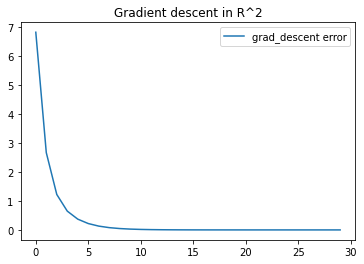

In [6]:
# Gradient descent minimization
x_grad, spins_grad = grad_descent(f, x_0)
print(f"Gradient descent result x* = {x_grad[-1]}")
print(f"f(x*) = {err(x_grad[-1])}")
print(f"D_f(x*) = {gradient(f, x_grad[-1])}")
print(f"iterations performed: {spins_grad}")

errors_grad = list(map(err, x_grad))
N = range(spins_grad + 1)

plt.title(f"Gradient descent in R^2")
plt.plot(N, errors_grad, label="grad_descent error")
plt.legend()
plt.show()

Here, the gradient descent method produces an accurate solution, and we can see that the convergence towards the exact solution in the plot above.

For Newton minimization, use same test case:

Newton minimization result x* = [-2.0000005  2.9999995 -5.0000005]
||solution - x*|| = 8.660254041618849e-07
D_f(x*) = [-4.44089057e-17  0.00000000e+00 -2.96059472e-16]
iterations performed: 3


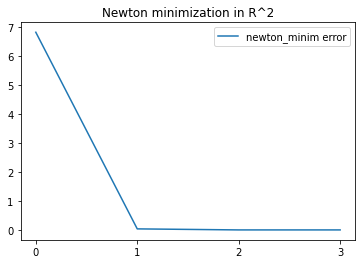

In [7]:
# Newton minimization
x_newt, spins_newt = newton_minim(f, x_0)
print(f"Newton minimization result x* = {x_newt[-1]}")
print(f"||solution - x*|| = {err(x_newt[-1])}")
print(f"D_f(x*) = {gradient(f, x_newt[-1])}")
print(f"iterations performed: {spins_newt}")

errors_newt = list(map(err, x_newt))
M = range(spins_newt + 1)

plt.title(f"Newton minimization in R^2")
plt.plot(M, errors_newt, label="newton_minim error")
plt.xticks(M)

plt.legend()
plt.show()

The Newton minimization method also produces an accurate result, and in the above plot we can see that it converges towards the exact solution very quickly, in fact it only needs a couple of iterations to find a critical point from the initial guess.

Comparing the two:

gradient descent ||solution - x*|| = 8.860375823466905e-07
newton minimization: ||solution - x*|| = 8.660254041618849e-07


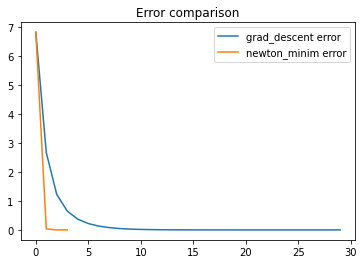

In [8]:
print(f"gradient descent ||solution - x*|| = {err(x_grad[-1])}")
print(f"newton minimization: ||solution - x*|| = {err(x_newt[-1])}")
plt.title("Error comparison")
plt.plot(N, errors_grad, label="grad_descent error")
plt.plot(M, errors_newt, label="newton_minim error")
plt.legend()
plt.show()

Here we can clearly see that the Newton minimization converges towards the exact solution much faster than the gradient descent method.

# **Discussion**

Newton's method was very effective at solving the constructed minimization problem. Selecting an interesting enough function $f$ took a little while, but the implementation should work for any function $f:R^n → R$.

Implementing these minimization functions was quite straightforward, although I got stuck for a while when working on the second functions, since at small values of $h$, approximating the *Hessian* was not very reliable.